# Überanpassung

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Daten

In [2]:
df = sns.load_dataset("titanic")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


# Model

In [4]:
# Features
features = ["class", "sex", "sibsp", "fare"]
X = df[features]
# Abhängige Variable
y = df["survived"]

X.isnull().any(axis = 1).sum()

0

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

## Entscheidungsbaum

Wir ezeugen nun das Klassisikationsmodell (decision tree classifier: tree_clf)

In [6]:
from sklearn import tree 

# Model erstellen
tree_clf = tree.DecisionTreeClassifier(max_depth=50)

# Model auf die Daten anwenden
tree_clf.fit(X_train, y_train);

Entscheidungsbaum visualisieren

In [7]:
class_names = ["Gestorben", "Überlebt"]
feature_names = X_train.columns

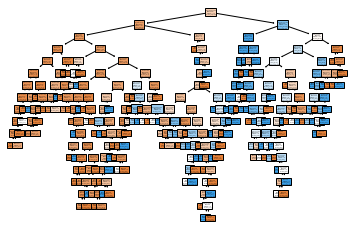

In [8]:
tree.plot_tree(tree_clf, feature_names=feature_names, class_names=class_names, filled=True);

Vorhersage für die Trainingsdaten durchführen

In [9]:
y_pred = tree_clf.predict(X_train)

## Fehlermatrix

Fehlermatrix erzeugen:

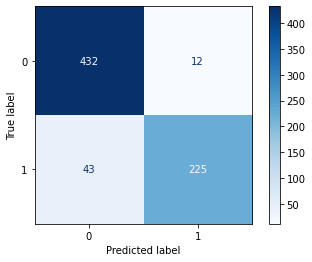

In [10]:
from sklearn import metrics

metrics.plot_confusion_matrix(tree_clf, X_train, y_train, cmap=plt.cm.Blues);

In [11]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       444
           1       0.95      0.84      0.89       268

    accuracy                           0.92       712
   macro avg       0.93      0.91      0.92       712
weighted avg       0.92      0.92      0.92       712



## ROC-Kurve

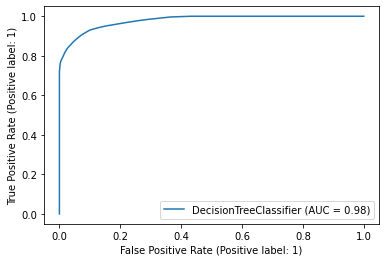

In [12]:
metrics.plot_roc_curve(tree_clf, X_train, y_train);  

Precision-Recall-Kurve:

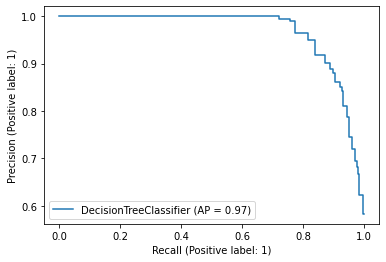

In [13]:
metrics.plot_precision_recall_curve(tree_clf, X_train, y_train);

# Evaluierung mit Testdaten

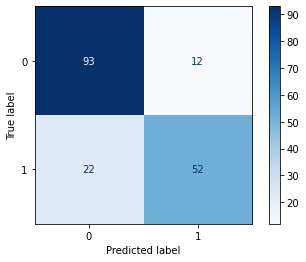

In [14]:
metrics.plot_confusion_matrix(tree_clf, X_test, y_test, cmap=plt.cm.Blues);

In [15]:
y_pred_test = tree_clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       105
           1       0.81      0.70      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



## Kalibrierung

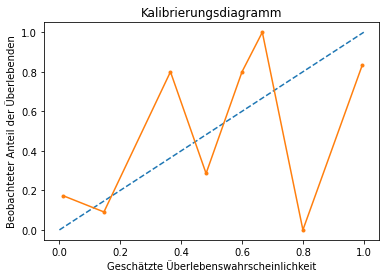

In [16]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

calibrator = CalibratedClassifierCV(tree_clf, cv=3)
calibrator.fit(X_train, y_train);

proba_survived = tree_clf.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, proba_survived, n_bins=10)

fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], linestyle='--')
ax.plot(prob_pred, prob_true, marker='.')
ax.set_xlabel('Geschätzte Überlebenswahrscheinlichkeit')
ax.set_ylabel('Beobachteter Anteil der Überlebenden')
ax.set_title(r'Kalibrierungsdiagramm');

## Brier Score

In [17]:
survived_prozent = round(sum(y_train)/len(y_train),2)
print("Gesamtanteil der Überlebenden in den Trainingsdaten:", survived_prozent, "\n")

n = len(y_test)
survived_heuristik = np.repeat(survived_prozent, n)  

brier_referenz = metrics.brier_score_loss(y_test, survived_heuristik)
brier_modell = metrics.brier_score_loss(y_test, proba_survived)

print(" Brier-Referenz:", round(brier_referenz, 3), "\n", "Brier-Modell:", round(brier_modell, 3), "\n")

brier_differenz = brier_referenz - brier_modell
skill_score = 100 * ((brier_differenz) / brier_referenz)

print("Der Unterschied zwischen den Brier Scores entspricht ", round(brier_differenz, 3), ", was einer ", round(skill_score, 2), "-prozentigen Verbesserung entspricht", sep="")

Gesamtanteil der Überlebenden in den Trainingsdaten: 0.38 

 Brier-Referenz: 0.244 
 Brier-Modell: 0.171 

Der Unterschied zwischen den Brier Scores entspricht 0.073, was einer 29.85-prozentigen Verbesserung entspricht
